# Time series analysis - Example code 22: Estimating the unknown parameters of an ARMA process using the Kalman filter

**Lund University, Lund, Sweden**

See also example 8.12.

**Reference:**  
"An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')

from tsa_lth.analysis import plotACFnPACF
from tsa_lth.analysis import plotWithConf
from tsa_lth.tests import whiteness_test, check_if_normal



## Simulate a process

In [2]:
# Simulate a process.
np.random.seed(50)                                   # Set the seed (just done for the lecture!)
extraN = 100
N  = 1000
A0 = np.array([1, -0.95])
C0 = np.array([1, 0.5, 0, -0.2])
e  = np.random.randn(N + extraN)
y  = lfilter(C0, A0, e)
y = y[extraN:]
e = e[extraN:]

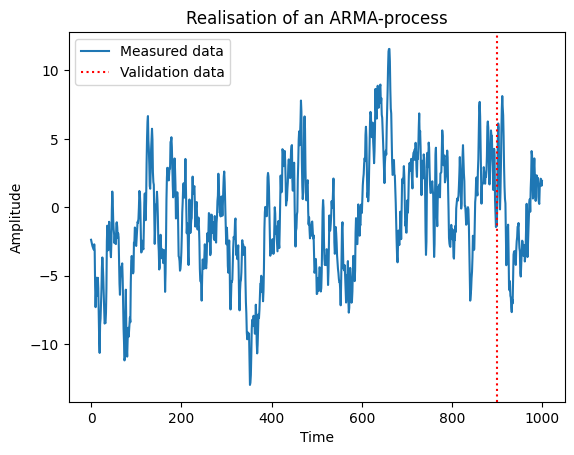

In [3]:
# Plot realisation. As an example, we here treat the last 100 samples as
# our validation data. The modeling set may be some earlier part, say,
# sample 400 to 600. It is on that part of the data we have decided the
# model structure to be estimated (not done in this example) - but note
# that the parameters estimated are from the start of time.
pstart = N - 100                                    # Start of the validation data.
plt.figure()
plt.plot(y, label='Measured data')
plt.axvline(x=pstart, color='red', linestyle=':', label='Validation data')
plt.legend(loc='upper left')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title('Realisation of an ARMA-process')
plt.show()

## Estimate the unknown parameters using a Kalman filter

In [4]:
# Estimate the unknown parameters using a Kalman filter.
p0 = 1                                              # Number of unknowns in the A polynomial.
q0 = 2                                              # Number of unknowns in the C polynomial.

A     = np.eye(p0 + q0)
Rw    = 1                                           # Measurement noise covariance matrix, R_w. Note that Rw has the same dimension as Ry.
Re    = 1e-6 * np.eye(p0 + q0)                      # System noise covariance matrix, R_e. Note that Re has the same dimension as Rx_t1.
Rx_t1 = np.eye(p0 + q0)                             # Initial covariance matrix, V0 = R_{1|0}^{x,x}
h_et  = np.zeros(N)                                 # Estimated one-step prediction error.
xt    = np.zeros((p0 + q0, N))                      # Estimated states. Intial state, x_{1|0} = 0.
yhat  = np.zeros(N)                                 # Estimated output.
xStd  = np.zeros((p0 + q0, N))                      # Stores one std for the one-step prediction.
yStd  = np.zeros(N)                                 # Stores one std for the one-step prediction.
for t in range(3, N):                               # We use t-3, so start at t=4.
    # Update the predicted state and the time-varying state vector.
    x_t1 = A @ xt[:, t-1]                           # x_{t|t-1} = A x_{t-1|t-1}
    C    = np.array([[-y[t-1], h_et[t-1], h_et[t-3]]])  # Use earlier prediction errors as estimate of e_t.
    
    # Update the parameter estimates.
    Ry = C @ Rx_t1 @ C.T + Rw                       # R_{t|t-1}^{y,y} = C R_{t|t-1}^{x,x} + Rw
    Kt = Rx_t1 @ C.T / Ry                           # K_t = R^{x,x}_{t|t-1} C^T inv( R_{t|t-1}^{y,y} )
    yhat[t] = (C @ x_t1)[0]                         # One-step prediction, \hat{y}_{t|t-1}.
    h_et[t] = y[t] - yhat[t]                        # One-step prediction error, \hat{e}_t = y_t - \hat{y}_{t|t-1}
    xt[:, t] = x_t1 + Kt[:, 0] * h_et[t]            # x_{t|t}= x_{t|t-1} + K_t ( y_t - Cx_{t|t-1} )

    # Update the covariance matrix estimates.
    Rx_t  = Rx_t1 - Kt @ Ry @ Kt.T                  # R^{x,x}_{t|t} = R^{x,x}_{t|t-1} - K_t R_{t|t-1}^{y,y} K_t^T
    Rx_t1 = A @ Rx_t @ A.T + Re                     # R^{x,x}_{t+1|t} = A R^{x,x}_{t|t} A^T + Re

    # Estimate a one std confidence interval of the estimated parameters.
    # This is only for the plots.
    xStd[:, t] = np.sqrt(np.diag(Rx_t))             # This is one std for each of the parameters for the one-step prediction.

    # Estimate a one std confidence interval of the one-step prediction.
    yStd[t] = np.sqrt(Ry[0, 0])                     # As the output is scalar, Ry is too.

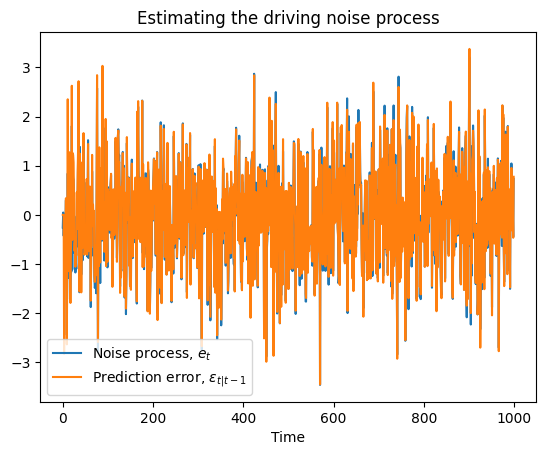

In [5]:
# Examine the estimate of the driving noise.
plt.figure()
plt.plot(e, label='Noise process, $e_t$')
plt.plot(h_et, label=r'Prediction error, $\epsilon_{t|t-1}$')
plt.xlabel('Time')
plt.title('Estimating the driving noise process')
plt.legend(loc='lower left')
plt.show()

## Examine the estimated parameters

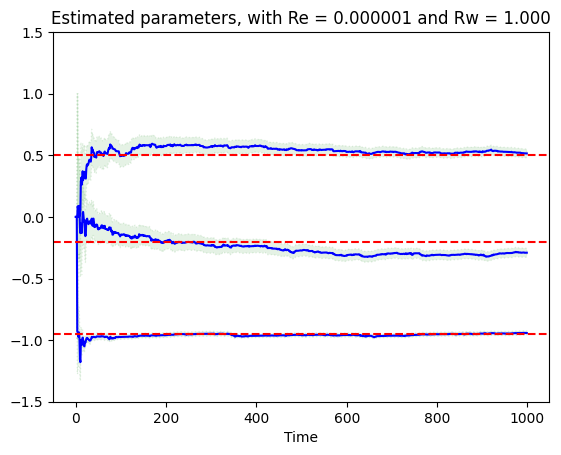

In [6]:
# Examine the estimated parameters.
# As with the command present, the precision is given with +/- one std.
trueParams = np.array([A0[1], C0[1], C0[3]])        # These are the true parameters we seek.
plt.figure()
plotWithConf(np.arange(N), xt.T, xStd.T, trueParams)
plt.title(f'Estimated parameters, with Re = {Re[0, 0]:.6f} and Rw = {Rw:.3f}')
plt.xlabel('Time')
plt.ylim([-1.5, 1.5])
plt.show()

In [7]:
# Examine the final predicted parameters.
print('The final values of the estimated parameters are:')
for k in range(len(trueParams)):
    print(f'  True value: {trueParams[k]:5.2f}, estimated value: {xt[k, -1]:5.2f} (+/- {xStd[k, -1]:5.4f}).')

The final values of the estimated parameters are:
  True value: -0.95, estimated value: -0.94 (+/- 0.0174).
  True value:  0.50, estimated value:  0.52 (+/- 0.0361).
  True value: -0.20, estimated value: -0.29 (+/- 0.0370).


## Show the one-step prediction with confidence interval

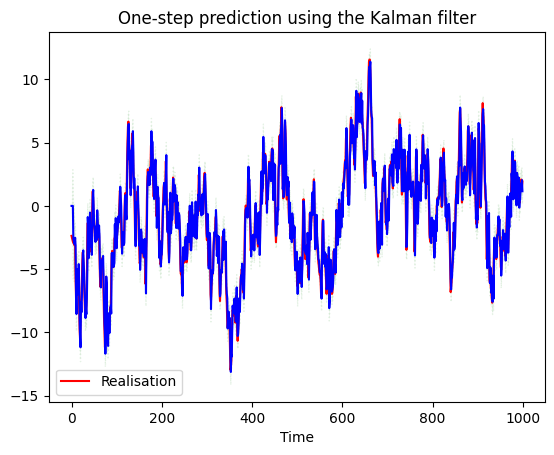

In [8]:
# Show the one-step prediction with confidence interval.
plt.figure()
plt.plot(y, 'r', label='Realisation')
plotWithConf(np.arange(N), yhat, yStd)
plt.title('One-step prediction using the Kalman filter')
plt.xlabel('Time')
plt.legend(loc='lower left')
plt.show()

## Examine one-step prediction residual

In [9]:
# Examine one-step prediction residual.
ey = y - yhat
ey = ey[pstart:N]                                   # Extract the validation data. Note that we in this way also ignore the initial values, allowing the filter converge.
whiteness_test(ey)

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 26.29 < 37.65)
  McLeod-Li test:        True (white if 14.71 < 37.65)
  Monti test:            True (white if 28.49 < 37.65)
  Sign change test:      True (white if 0.57 in [0.40,0.60])


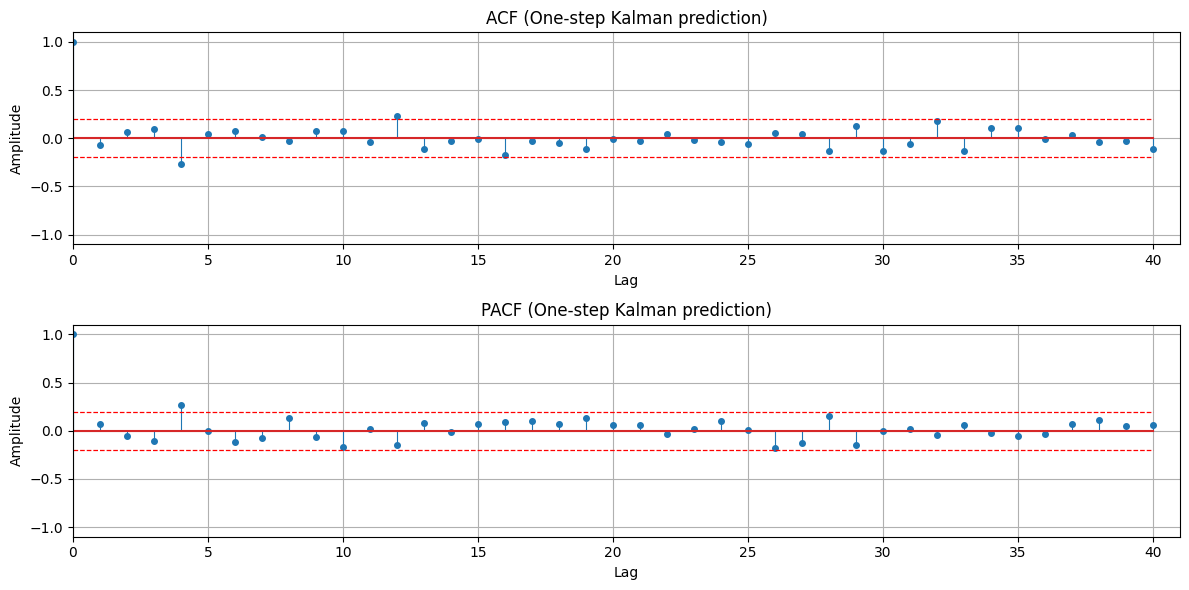

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


In [10]:
acfEst, pacfEst = plotACFnPACF(ey, 40, 'One-step Kalman prediction', return_val=True)
check_if_normal(pacfEst[1:], which_test='D', alpha=0.05)